In [4]:
import numpy as np
from floquet_simulations.plot_functions import PlotParams,truncate_colormap

PlotParams(fontsize=8/0.9)
from floquet_simulations.hamiltonians import GetEvalsAndEvecsGen

from scipy.integrate import solve_ivp
from floquet_simulations.hamiltonians import RoundComplex

from floquet_simulations.plot_functions import PlotAbsRealImagHamiltonian
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.special import jv, jn_zeros, jnp_zeros
from pathlib import Path
import matplotlib.patches as patches

In [5]:
def H0_Lieb():
    H0 = np.zeros((21,21))
    links = [(1,2), (2,3), (3,4), (4,5), (1,6), (3,7), (5,8), (6,9), (7,11), (8,13), (9,10), (10,11), (11,12), (12,13), (9,14), (11,15), (13,16), 
            (14,17), (15,19), (16,21), (17,18), (18,19), (19,20), (20,21)]
    for link in links:
        H0[link[0]-1, link[1]-1] = -1
        H0[link[1]-1, link[0]-1] = -1
    return H0

def HT(H0, funcs, sites, t):

    for func, site in zip(funcs, sites):
        H0[site-1,site-1] = func(t)
    return H0

def FT(t, psi, H0, funcs, sites):
    H = HT(H0, funcs, sites, t)
    return -1j*np.dot(H, psi)

def SolveSchrodinger(H0, funcs, sites, tspan, n_timesteps, psi0):
    
    rtol=1e-11
    # points to calculate the matter wave at
    t_eval = np.linspace(tspan[0], tspan[1], n_timesteps+1, endpoint=True)
    sol = solve_ivp(lambda t,psi: FT(t, psi, H0, funcs, sites), 
            t_span=tspan, y0=psi0, rtol=rtol, 
            atol=rtol, t_eval=t_eval,
            method='RK45')
    sol=sol.y
    return sol


def CreateHF(H0, funcs, sites, T, num_sites, t0=0, hermitian_accuracy_dp=7): 
    """
    t0 is fraction of T
    """

    #sanity check
    assert(len(H0) == num_sites)
    
    tspan = (t0*T,T+t0*T)
    UT = np.zeros([num_sites, num_sites], dtype=np.complex_)
    n_timesteps = 100
    
    for A_site_start in range(num_sites):
        psi0 = np.zeros(num_sites, dtype=np.complex_); psi0[A_site_start] = 1
        sol = SolveSchrodinger(H0, funcs, sites, tspan, n_timesteps, psi0)
        UT[:,A_site_start]=sol[:,-1] 
    
    # evals_U, evecs = eig(UT)
    evals_U, evecs = GetEvalsAndEvecsGen(UT) #evals can be imaginary
    evals_H = 1j / T *np.log(evals_U)
    
    HF = np.zeros([num_sites,num_sites], dtype=np.complex_)
    for i in range(num_sites):
        term = evals_H[i]*np.outer(evecs[:,i], np.conj(evecs[:,i]))
        HF = HF+term

    HF = RoundComplex(HF, hermitian_accuracy_dp)
    # assert(np.all(0 == (HFr - np.conj(HFr.T))))
    return UT, HF
    # if np.all(0 == (HF - np.conj(HF.T))):
    #     return UT, HF
    # else:
    #     return np.nan, np.nan



## shake same frequency

A1=72.14476673087319,A2=0,A3=0,A4=0
$\epsilon_7=(-0.3352405+0j)$


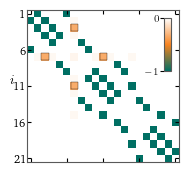

In [3]:
omega = 40


# A1 = jnp_zeros(0,1)[0]*omega
A1 = 3*jn_zeros(0,1)[0]*omega/4#jnp_zeros(0,1)[0]*omega
A2 = 0; A3 = 0; A4 = 0
print(f"A1={A1},A2={A2},A3={A3},A4={A4}")

T = 2*np.pi/omega
funcs = [lambda x: A1*np.cos(omega*x),
         lambda x: A2*np.cos(omega*x),
         lambda x: A3*np.cos(omega*x),
         lambda x: A4*np.cos(omega*x)]
sites = [7, 10, 12, 15]

_, HF = CreateHF(H0_Lieb(), funcs, sites, T, num_sites=21, t0=0, hermitian_accuracy_dp=7)

print(fr"$\epsilon_7={HF[6,2]}$")
# Just show real bit
figsize = (5, 5)
colourbar_pad=0.1
colourbar_size_percentage=5
save_location = False
absMax = np.max([np.abs(np.min(np.real(HF))),
                np.abs(np.max(np.real(HF))),
                np.abs(np.min(np.imag(HF))),
                np.abs(np.max(np.imag(HF)))])

# norm = mpl.colors.Normalize(vmin=-absMax, vmax=absMax)
# linthresh = 1e-1
# norm=mpl.colors.SymLogNorm(linthresh=linthresh, linscale=1, vmin=-1.0, vmax=1.0, base=10)

label= r'$[H_S^{t_0}]_{i,j}$'

data_cmap_lims = (-1, 0); colourbar_cmap_lims=(-1,0); colourbar_ticks = np.arange(-1,0.1,1)
norm = mpl.colors.Normalize(vmin=data_cmap_lims[0], vmax=data_cmap_lims[1])
cmap = LinearSegmentedColormap.from_list('custom hamiltonians', ['#006F63',  '#F78320', "#FFFFFF"], N=256)


cm_unit = 1/2.54
fig, ax = plt.subplots(figsize=(figsize[0]*cm_unit, figsize[1]*cm_unit))

# fig.suptitle(rf"$\omega={omega1}, A_1 ={A1}, A_2 = {A2}, A_3 = {A3}, A_4 = {A4}$")
pcm = ax.matshow(np.real(HF), interpolation='none', cmap=cmap,  norm=norm)
# ax.set_title(label)
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=False, 
        labeltop=False, direction = "in", length = 3)  
ax.tick_params(axis="y", left=True, right=True, labelleft=True, 
        labelright=False, direction = "in", length = 3, pad=1)  

# ax.set_xlabel('m')
# ax.set_xticks(np.arange(0,21,2))
# ax.set_xticklabels(np.arange(1,22,2))

ax.yaxis.set_label_coords(-0.1,0)
ax.set_ylabel('$i$', rotation=0)
ax.set_yticks(np.arange(0,21,5))
ax.set_yticklabels(np.arange(1,22,5))

# Create a Rectangle patch
origin_topleft = np.array([-0.6, -0.6])
x_gap = 21.1/21+0.01; y_gap = 1

for square_index in [(11,7), (3,7), (7,3), (7,11)]:
    rect = patches.Rectangle(tuple(origin_topleft+np.array([(square_index[0]-1)*x_gap, (square_index[1]-1)*y_gap])), 1, 1, linewidth=0.25, edgecolor='#000000', facecolor='none')
    ax.add_patch(rect)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
new_norm = mpl.colors.Normalize(vmin=colourbar_cmap_lims[0], vmax=colourbar_cmap_lims[1])
new_cmap = truncate_colormap(cmap, (colourbar_cmap_lims[0]-data_cmap_lims[0])/(data_cmap_lims[1] - data_cmap_lims[0]), (colourbar_cmap_lims[1]-data_cmap_lims[0])/(data_cmap_lims[1] - data_cmap_lims[0]))
axins = inset_axes(
    ax,
    width="5%",  # width: 5% of parent_bbox width
    height="50%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(0.9, 0.6, 1, 0.7),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=new_norm, cmap=new_cmap), cax=axins, ticks=colourbar_ticks, ticklocation="left")
cbar.ax.tick_params(labelsize=7, pad=0)

# fig.savefig(Path().absolute().parent.parent.parent/"figures"/"local_mod_paper"/"lieb_lattice_shake1.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

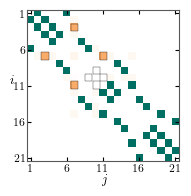

72.14476673087319 96.19302230783092 0 0


In [219]:
A1 = 3*jn_zeros(0,1)[0]*omega/4#jnp_zeros(0,1)[0]*omega
A3 = 0; A4 = 0
A2 = jn_zeros(0,1)[0]*omega

print(f"A1={A1},A2={A2},A3={A3},A4={A4}")



T = 2*np.pi/omega
funcs = [lambda x: A1*np.cos(omega*x),
         lambda x: A2*np.cos(omega*x),
         lambda x: A3*np.cos(omega*x),
         lambda x: A4*np.cos(omega*x)]
sites = [7, 10, 12, 15]

_, HF = CreateHF(H0_Lieb(), funcs, sites, T, num_sites=21, t0=0, hermitian_accuracy_dp=7)

colourbar_pad=0.1
colourbar_size_percentage=5
save_location = False
absMax = np.max([np.abs(np.min(np.real(HF))),
                np.abs(np.max(np.real(HF))),
                np.abs(np.min(np.imag(HF))),
                np.abs(np.max(np.imag(HF)))])

           
cm_unit = 1/2.54
fig, ax = plt.subplots(figsize=(figsize[0]*cm_unit, figsize[1]*cm_unit))

# fig.suptitle(rf"$\omega={omega1}, A_1 ={A1}, A_2 = {A2}, A_3 = {A3}, A_4 = {A4}$")
pcm = ax.matshow(np.real(HF), interpolation='none', cmap=cmap,  norm=norm)
# ax.set_title(label)
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, 
        labeltop=False, direction = "in", length = 3,  pad=2)  
ax.tick_params(axis="y", left=True, right=True, labelleft=True, 
        labelright=False, direction = "in", length = 3, pad=1)  
ax.xaxis.set_label_coords(0.5,-0.09)
ax.set_xlabel('$j$')
ax.set_xticks(np.arange(0,21,5))
ax.set_xticklabels(np.arange(1,22,5))


ax.yaxis.set_label_coords(-0.1,1)
ax.set_ylabel('$i$', rotation=0)
ax.set_yticks(np.arange(0,21,5))
ax.set_yticklabels(np.arange(1,22,5))




# for origin in [(8.39, 9.41), (9.39, 8.41), (8.39, 7.41), (7.39, 8.41)]:
#         rect = patches.Rectangle(origin, 0.99, 0.99, linewidth=0.2, edgecolor='#000000', facecolor='none')
#         ax.add_patch(rect)
for square_index in [(11,7), (3,7), (7,3), (7,11), (11,10), (9,10), (10, 9), (10, 11)]:
    rect = patches.Rectangle(tuple(origin_topleft+np.array([(square_index[0]-1)*x_gap, (square_index[1]-1)*y_gap])), 1, 1, linewidth=0.25, edgecolor='#000000', facecolor='none')
    ax.add_patch(rect)

# rect = patches.Rectangle((-0.6, -0.6), 21.1, 21, linewidth=1, edgecolor='r', facecolor='none')
# ax.add_patch(rect)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size=f"{colourbar_size_percentage}%", pad=colourbar_pad)
# fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)# label="unweighted graph distance")
# fig.savefig(Path().absolute().parent.parent.parent/"figures"/"local_mod_paper"/"lieb_lattice_shake2.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

print(A1, A2, A3, A4)

72.14476673087319


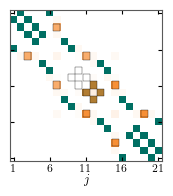

In [220]:
# omega = 10
A1 = 3*jn_zeros(0,1)[0]*omega/4#jnp_zeros(0,1)[0]*omega
A2 = jn_zeros(0,1)[0]*omega
A3 = 50; A4 = 64


print(A1)


T = 2*np.pi/omega
funcs = [lambda x: A1*np.cos(omega*x),
         lambda x: A2*np.cos(omega*x),
         lambda x: A3*np.cos(omega*x),
         lambda x: A4*np.cos(omega*x)]
sites = [7, 10, 12, 15]

_, HF = CreateHF(H0_Lieb(), funcs, sites, T, num_sites=21, t0=0, hermitian_accuracy_dp=7)


cm_unit = 1/2.54
fig, ax = plt.subplots(figsize=(figsize[0]*cm_unit, figsize[1]*cm_unit))

# fig.suptitle(rf"$\omega={omega1}, A_1 ={A1}, A_2 = {A2}, A_3 = {A3}, A_4 = {A4}$")
pcm = ax.matshow(np.real(HF), interpolation='none', cmap=cmap,  norm=norm)
# ax.set_title(label)
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, 
        labeltop=False, direction = "in", length = 3, pad=2)  
ax.tick_params(axis="y", left=True, right=True, labelleft=False, 
        labelright=False, direction = "in", length = 3)  

ax.xaxis.set_label_coords(0.5,-0.09)
ax.set_xlabel('$j$')
ax.set_xticks(np.arange(0,21,5))
ax.set_xticklabels(np.arange(1,22,5))

for square_index in [(11,7), (3,7), (7,3), (7,11), (11,10), (9,10), (10, 9), (10, 11), (11,12), (13, 12), (12,11), (12, 13), (15, 11), (15, 19), (11, 15), (19, 15)]:
    rect = patches.Rectangle(tuple(origin_topleft+np.array([(square_index[0]-1)*x_gap, (square_index[1]-1)*y_gap])), 1, 1, linewidth=0.25, edgecolor='#000000', facecolor='none')
    ax.add_patch(rect)

# ax.yaxis.set_label_coords(-0.21,1.6)
# ax.set_ylabel('$i$', rotation=0)
# ax.set_yticks(np.arange(0,21,5))
# ax.set_yticklabels(np.arange(1,22,5))

fig.savefig(Path().absolute().parent.parent.parent/"figures"/"local_mod_paper"/"lieb_lattice_shake3.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()